## The Context

The thesis of this post is pretty simple. There is a delay between customers making a transaction and when *Afterpay* realises they have defaulted. Because of this delay, combined with the rapid growth in the total value of transactions, defaults may be artificially reduced as a percentage of transaction value. 





:::{.callout-important}

Obviously, I need a disclaimer. If you use anything I say as the basis for any decision, financial or otherwise, you are an idiot.

:::


## The Model

First off, let's load in a bunch of libraries.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from io import StringIO
import pandas as pd

import scipy.optimize

plt.rcParams["figure.figsize"] = (10,10)
from warnings import filterwarnings
filterwarnings('ignore')

While reading through Afterpay's releases to the markets, I came across this chart, which appears on page 3 of [this](https://www.afterpaytouch.com/images/APT_ASX-Announcement_Q2-FY18_16-Jan-Final-2.pdf) release. Let's use this to build a simple quadratic model of the reported sales. 


![Image of Afterpay customer growth](../images/2020-08-13-Modelling-Afterpays-Customer-Growth/CustomerGrowth.png)

## Loading the data

In [2]:
#Underlying sales
csv_data = StringIO('''anz_underlying_sales_value,date,month_count
0,FY15,0
37.3,FY16,12
561.2,FY17,24
2184.6,FY18,36
4314.1,FY19,48
6566.9,FY20,60''')

df = pd.read_csv(csv_data, sep=",")

## Fitting a curve

Let's first fit quadratic: 

In [3]:
def quadratic(t, a, b, c):
    y = a * t**2 + b * t + c
    return y

xdata = df.month_count.values
ydata = df.anz_underlying_sales_value.values

popt, pcov = scipy.optimize.curve_fit(quadratic, xdata, ydata)

print(popt)

[  2.17012649 -17.61639881 -58.725     ]


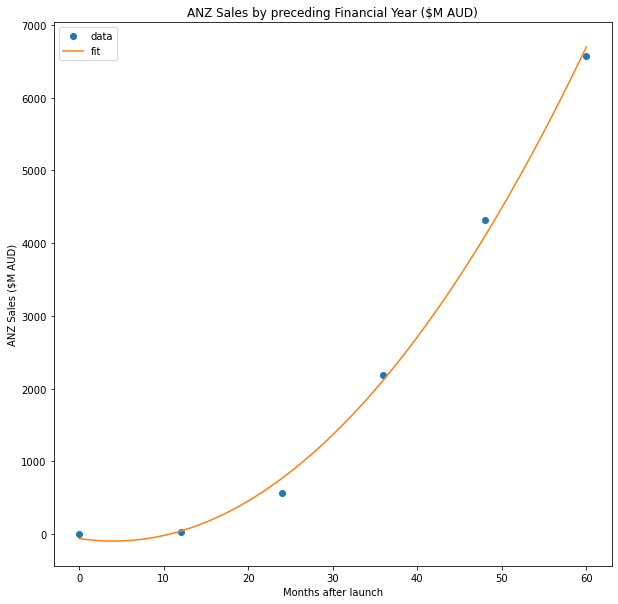

In [4]:
x = np.linspace(0,60, 61)
y = quadratic(x, *popt)

plt.plot(xdata, ydata, 'o', label='data')
plt.plot(x,y, label='fit')

plt.title('ANZ Sales by preceding Financial Year ($M AUD)')
plt.xlabel('Months after launch')
plt.ylabel('ANZ Sales ($M AUD)')
plt.legend(loc='best')
plt.show()

## Delays in reporting.

So we found that we could model the annual reported sales as $$2.170 t^2 - 17.61t - 58.725$$ 

The instantaneous sales rate is $$0.1808t^2 + 0.7021t -9.36$$.

Don't worry about how I arrived at this; I will show how in the appendix of this post.


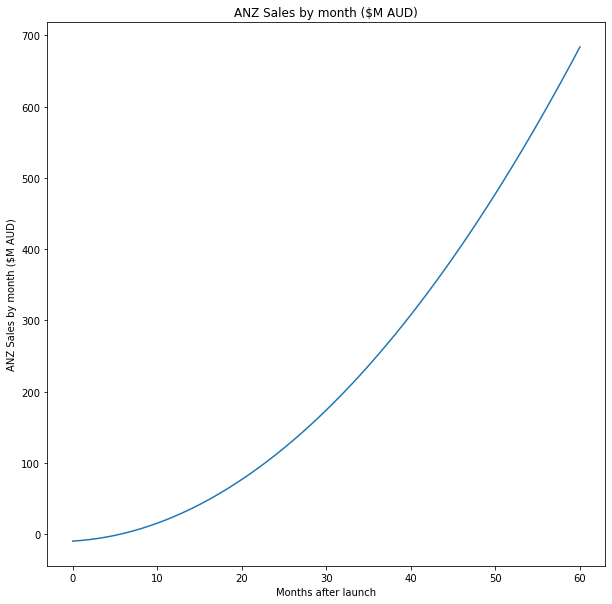

In [5]:
t = np.linspace(0,60, 61)
sales = 0.1808*t**2 + 0.7021* t - 9.36

plt.plot(sales)

plt.title('ANZ Sales by month ($M AUD)')
plt.xlabel('Months after launch')
plt.ylabel('ANZ Sales by month ($M AUD)')
plt.show()

Now let's model a delay of 6 months between when the transaction happens and when *Afterpay* finally realised there was a default.

From this, we can see a significant difference between the actual rate at which losses occur and the rate at which we observe them occurring at any time.

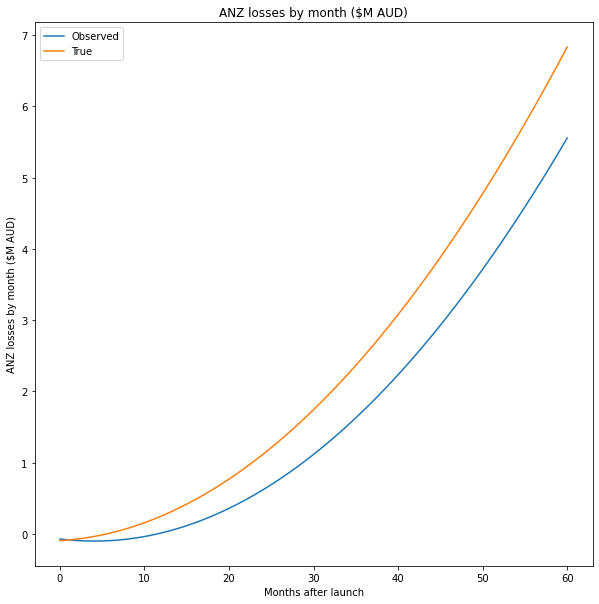

In [6]:
delay = 6 #months 
true_loss_rate = 0.01

losses_true = true_loss_rate*(0.1808*t**2 + 0.7021* t - 9.36)
losses_observed = true_loss_rate*(0.1808*(t-delay)**2 + 0.7021* (t-delay) - 9.36)
plt.plot(losses_observed,label='Observed')
plt.plot(losses_true,label='True')

plt.legend()
plt.title('ANZ losses by month ($M AUD)')
plt.xlabel('Months after launch')
plt.ylabel('ANZ losses by month ($M AUD)')
plt.show()

Now let's integrate by financial year.

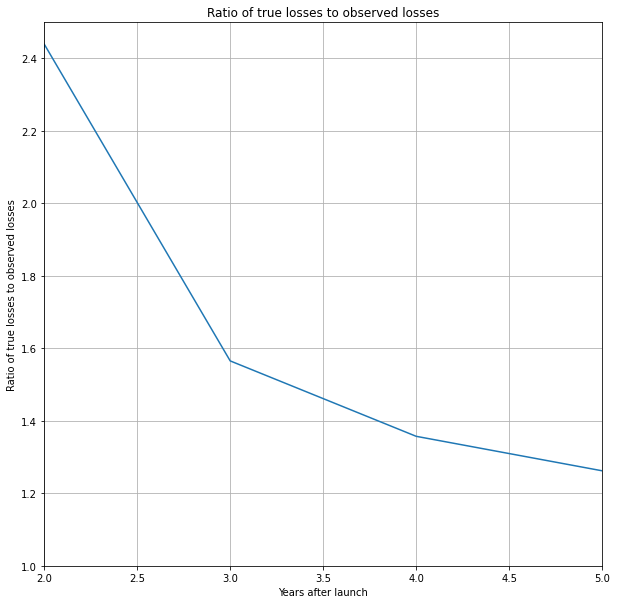

In [7]:
def integrate_by_year(y):
    integrated = np.array([0,np.sum(y[0:12]),np.sum(y[12:24]),np.sum(y[24:36]),np.sum(y[36:48]),np.sum(y[48:60])])
    return(integrated)


observed_loss_rate = integrate_by_year(losses_true)/integrate_by_year(losses_observed)

plt.plot(observed_loss_rate)

plt.title('Ratio of true losses to observed losses')
plt.xlabel('Years after launch')
plt.ylabel('Ratio of true losses to observed losses')
plt.ylim(1,2.5)
plt.xlim(2,5)
plt.grid()
plt.show()

## Conclusion
In conclusion, we can see the impact of a delay in recognising losses in situations with rapid growth. Even after years of growth, with a six-month delay in recognising losses, the actual losses could be 30-40% higher than reported.


# Appendix


### Finding an integral


So we found that we could model the annual reported sales as $$2.170 t^2 - 17.61t - 58.725$$ 

Let's call this function $f(t)$

We want to find the function $g(t)$, which is the underlying sales rate I claimed was: $$0.1808t^2 + 0.7021t -9.36$$.

When integrated over 12 months, this function will give us the annual reported sales.

To help us with the algebraic manipulation, we can use [Sympy](https://docs.sympy.org/latest/index.html). An alternative is to do the algebraic manipulation by hand, which is probably faster and more scalable.



In [ ]:
import sympy as sym
sym.init_printing(use_unicode=True)

a,b,c,d,t = sym.symbols('a b c d t')

We are looking for a quadratic function, the definite integral of which is equal to $$2.170 t^2 - 17.61t - 58.725$$. Let's start by forming the definite integral.

In [8]:
expr = sym.simplify((a*t**3 + b*t**2 + c*t + d) - (a*(t-12)**3 + b*(t-12)**2 + c*(t-12) + d))  

In [9]:
print(sym.collect(expr,t))

36*a*t**2 + 1728*a - 144*b + 12*c + t*(-432*a + 24*b)


In [10]:
fitted_quadratic = t**2 * 2.17012649 + t*-17.61639881 -58.725

### Solving for the coefficients

Let's now form a set of simultaneous equations and solve for each of the coefficients of $t$.

In [11]:
equations = []
for i in [2,1,0]:
    eq = sym.collect(expr,t).coeff(t, i)
    coeff = sym.collect(fitted_quadratic,t).coeff(t, i)
    equations.append(sym.Eq(eq,coeff))

result = sym.solve(equations,(a,b,c))

print(result)

{a: 0.0602812913888889, b: 0.351046627916667, c: -9.36169642500000}


### Finding the derivative

Now all that's left to do is find the derivative of the indefinite integral. 

In [12]:
expr = result[a] * t**3 + result[b]*t**2 + result[c]*t

print(sym.diff(expr, t))

0.180843874166667*t**2 + 0.702093255833333*t - 9.361696425


Voilà!